In [50]:
import os
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import matplotlib.pyplot as plt
import numpy as np
import OT2_Ouzo_Commands as ot2_commands
from opentrons import simulate, execute, protocol_api

In [60]:
experiment_dict = create.get_experiment_plan(r"C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Testing Plans\Testing_Example.csv") # Intialize master dictionary from excel sheet
# make unique id auto (DDMMYY)
component_dict = create.dict_creator(experiment_dict, 'Component') # Gather all information concerning components into one dictionary
stock_dict = create.dict_creator(experiment_dict, 'Stock') 
opentrons_dict = create.dict_creator(experiment_dict, 'OT2')

In [61]:
total_sample_mass = experiment_dict['Sample Mass']
wtf_sample_canidates = create.generate_candidate_lattice_concentrations(component_dict) # there is a built in filter for anything summing to over 1, could be somewhat informative
stock_volumes_canidates = create.calculate_volumes(total_sample_mass, wtf_sample_canidates, component_dict, stock_dict) # created in uL
filtered_wtf_samples, filtered_volume_samples = create.filter_samples(wtf_sample_canidates, stock_volumes_canidates, 30, 1000)
print('sample filtered out =', len(stock_volumes_canidates)-len(filtered_volume_samples))
print('samples remaining =', len(filtered_volume_samples))

sample filtered out = 59
samples remaining = 41


In [62]:
# for i in filtered_wtf_samples:
#     print(i[2],i[3])

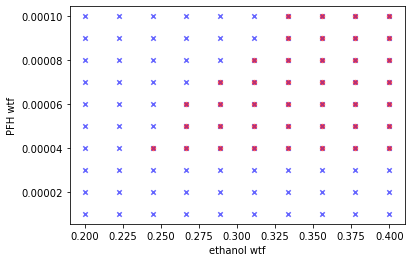

In [63]:
create.graph_canidates(component_dict, wtf_sample_canidates, filtered_wtf_samples)
# add in other information
# log scale/scinot 

In [64]:
component_volume_lists = create.rearrange(filtered_volume_samples)
print(component_volume_lists[3])
protocol = simulate.get_protocol_api('2.0')
info_list = ot2_commands.run(protocol, experiment_dict, opentrons_dict, component_volume_lists) # produce info

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


[35.54842198751085, 48.815081922410606, 61.95780616468999, 74.97207758843328, 87.85340722699647, 100.59735427436937, 113.19954608653774, 125.65569818284541, 39.80143291924495, 52.944157161524345, 65.95842858526763, 78.83975822383083, 91.58370527120371, 104.18589708337208, 116.64204917967977, 30.787783916079338, 43.93050815835872, 56.94477958210201, 69.8261092206652, 82.5700562680381, 95.17224808020647, 107.62840017651415, 34.916859155193045, 47.93113057893633, 60.812460217499535, 73.55640726487242, 86.15859907704079, 98.61475117334848, 38.91748157577069, 51.79881121433388, 64.54275826170678, 77.14495007387515, 89.60110217018283, 42.785162211168235, 55.529109258541126, 68.1313010707095, 80.58745316701719, 33.77151320800262, 46.51546025537551, 59.11765206754388, 71.57380416385156]
Picking up tip from A1 of Opentrons 96 Tip Rack 1000 µL on 5
Transferring 48.75000283042516 from A1 of Corning 96 Well Plate 360 µL Flat on 1 to A1 of Corning 96 Well Plate 360 µL Flat on 2
Aspirating 48.750002

In [124]:
import datetime
from pytz import timezone
import csv

In [130]:
time = str(datetime.datetime.now(timezone('US/Pacific')).date()) # should be embaded once you run
component_names = component_dict['Component Shorthand Names']

UID_header = ['UID']
slot_header = ['Slot']
labware_header = ['Labware']
well_header =['Well']
general_component_header = []
experiment_component_header = []

for i in range(len(component_names)):
    general_component_header.append('Component ' + str(i+1))
    experiment_component_header.append(component_names[i])

complete_header = UID_header + general_component_header + slot_header + labware_header + well_header
complete_experiment_header = UID_header + experiment_component_header + slot_header + labware_header + well_header

"""This will only work with the simple case of adding component wise (aka adding all components then moving to next one)
Takes the information from the first OT2 command that goes over the whole plate.
A more static approach would be just to assume len of list = wells and slot and labware are static"""
wells = []
labwares = []
slots = []
info_cut = info_list[0:len(filtered_wtf_samples)]
for info in info_cut:
    str_info = str(info) # contains well labware and slot
    well = str_info[0:2]
    wells.append(well)
    labware = str_info[6:-4] # can be static as the slot and only at max be len 2
    labwares.append(labware)
    slot = str_info[-1:]
    slots.append(slot)

csv_entries = []
## Adding unique id and other information into one sublist to be fed as row into writer
for component_wtfs, well, slot, labware in zip(filtered_wtf_samples, wells, slots, labwares):
    UID = time + "_" +component_dict['Component Shorthand Names'][component_dict['Component Graphing X Index']]+ "_" + component_dict['Component Shorthand Names'][component_dict['Component Graphing Y Index']] + "_" + well
    csv_entry = [UID] + component_wtfs.tolist() + [well] + [slot] + [labware]
    csv_entries.append(csv_entry)

In [131]:
filename = 'C:\\Users\\Edwin\\Desktop\\test_writing_samples1.csv'
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter = ",")
    csvwriter.writerow(complete_header)
    csvwriter.writerow(complete_experiment_header) # so what 
    
    for row in csv_entries:
        csvwriter.writerow(row)
        